In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
from math import floor
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
from quantities import Hz, s, ms

from infomap import Infomap, MultilayerNode
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [3]:
def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array = array
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array, thresh = None):
    if thresh == None: thresh = 0
    n,t = array.shape
    binary_spikes = np.zeros((n,t), dtype = bool)
    for i in range(n):
        for j in range(t):
            if array[i][j] < thresh: pass
            else: binary_spikes[i][j] = True
    return(binary_spikes)

def threshold(array, thresh):
    n,t = array.shape
    thresholded_array = np.copy(array)
    for i in range(n):
        for j in range(t):
            if array[i][j] < thresh: thresholded_array[i][j] = 0
            else: pass
    return(thresholded_array)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def community(n,t,membership, ax):

    number_of_colors = len(membership)

    comms = np.zeros((n,t))

    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

    for i, l in enumerate(membership):
        for j,k in enumerate(l):
            comms[k[0]][k[1]] = i

    cmap = mpl.colors.ListedColormap(color)

    ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n+0.5])
    ax.set_xticks([i for i in range(t)])
    ax.set_yticks([i*10 for i in range(int(n/10)+1)])
    ax.tick_params(axis = 'both', labelsize = 15)
    ax.set_xlabel('Layers (Time)', fontsize = 18)
    ax.set_ylabel('Neuron ID', fontsize = 18)
    ax.set_title('Infomap, %d Communities Found' %len(color), fontsize = 20)
    return(comms, color)

In [4]:
def generate_ground_truth(comm_sizes, method = 'scattered', pad = False, community_operation = 'grow'):
    ##genertaes community labels according to two methods one in which the rest of the network except the planted communities
    # are scattered i.e. they all have their own community or they are all in one community, integrated.
    if community_operation == 'grow':
        layers = len(comm_sizes)
        if method == 'scattered':
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + list(np.arange(1, sum(comm_sizes[1:])+1))
            if pad: truth_labels = truth_labels + truth_labels
            
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + list(np.arange(np.max(truth_labels)+1, np.max(truth_labels)+ 1 + sum(comm_sizes[j:])))
        
            if pad:
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]  
        
        if method == 'integrated':
        
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + [1 for i in range(sum(comm_sizes[1:]))]
            if pad: truth_labels = truth_labels + truth_labels
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + [1 for i in range(sum(comm_sizes[j:]))]

            if pad:
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
    elif community_operation == 'merge':##only for two layers
        truth_labels = []
        p = 0
        for i,e in enumerate(comm_sizes):
            for j,f in enumerate(e):
                truth_labels = truth_labels + [p+j for k in range(f)]
            p = p+len(comm_sizes[i])
        if pad:
            l1 = truth_labels[:sum(comm_sizes[0])]
            l2 = truth_labels[sum(comm_sizes[0]):]
            truth_labels = l1 + truth_labels +l2
    return(truth_labels)

def information_recovery(pred_labels, comm_size, truth, interlayers, thresholds, com_op):
    NMI1 = np.zeros((len(interlayers), len(thresholds)))
    ARI1 = np.zeros((len(interlayers), len(thresholds)))
    F1S1 = np.zeros((len(interlayers), len(thresholds)))
    
    if truth == 'Scattered': true_labels = generate_ground_truth(comm_size, method = 'scattered', pad = True, community_operation = com_op)
    if truth == 'Integrated': true_labels = generate_ground_truth(comm_size, method = 'integrated', pad = True, community_operation = com_op)

    
    for i in range(len(thresholds)):
        for j in range(len(interlayers)):
            NMI1[j][i] = normalized_mutual_info_score(true_labels, list(pred_labels[i*len(interlayers)+j].astype(int)), average_method = 'max')
            ARI1[j][i] = adjusted_rand_score(true_labels, list(pred_labels[i*len(interlayers)+j].astype(int)))
            F1S1[j][i] = f1_score(true_labels, list(pred_labels[i*len(interlayers)+j].astype(int)), average = 'weighted')
        
    fig,ax = plt.subplots(1,3, figsize = (50, 25))
    c = ax[0].imshow(NMI1, origin = 'lower', 
                     interpolation = 'none', 
                     cmap = 'Reds', aspect = 'auto',
                     extent = [thresholds[0]-0.005, thresholds[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

    c = ax[1].imshow(ARI1, origin = 'lower', 
                     interpolation = 'none', 
                     cmap = 'Reds', aspect = 'auto',
                     extent = [thresholds[0]-0.005, thresholds[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

    c = ax[2].imshow(F1S1, origin = 'lower',
                     interpolation = 'none', 
                     cmap = 'Reds', aspect = 'auto',
                     extent = [thresholds[0]-0.005, thresholds[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

    ax[0].set_title('NMI wrt %s Ground Truth'%truth, fontsize = 30)
    ax[0].set_xlabel('Thresholds', fontsize = 25)
    ax[0].set_ylabel('Interlayers', fontsize = 25)
    ax[0].set_xticks(thresholds)
    ax[0].set_yticks(interlayers)
    ax[0].tick_params(axis = 'both', labelsize = 5)

    ax[1].set_title('ARI wrt %s Ground Truth'%truth, fontsize = 30)
    ax[1].set_xlabel('Thresholds', fontsize = 25)
    ax[1].set_ylabel('Interlayers', fontsize = 25)
    ax[1].set_xticks(thresholds)
    ax[1].set_yticks(interlayers)
    ax[1].tick_params(axis = 'both', labelsize = 5)

    ax[2].set_title('F1-Score wrt %s Ground Truth'%truth, fontsize = 30)
    ax[2].set_xlabel('Thresholds', fontsize = 25)
    ax[2].set_ylabel('Interlayers', fontsize = 25)
    ax[2].set_xticks(thresholds)
    ax[2].set_yticks(interlayers)
    ax[2].tick_params(axis = 'both', labelsize = 5)
    
    cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal', ticks = [i*0.1 for i in range(11)])
    
def display_truth(comm_sizes, community_operation):
    if community_operation == 'grow':
        n = sum(comm_sizes)
        layers = len(comm_sizes)
        l = layers + 2
    
        scattered_truth = generate_ground_truth(comm_sizes, 
                                                method = 'scattered', 
                                                pad = True, 
                                                community_operation = community_operation)
        number_of_colors = max(scattered_truth)+1
    
        membership = [[] for i in range(number_of_colors)]
        for i,m in enumerate(scattered_truth):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        fig,ax = plt.subplots(1,2, figsize = (16,8))

        comms = np.zeros((n,layers+2))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax[0].imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
        ax[0].set_xticks([i for i in range(layers+2)])
        ax[0].set_yticks([i*10 for i in range(int(n/10)+1)])
        ax[0].tick_params(axis = 'both', labelsize = 15)
        ax[0].set_xlabel('Layers (Time)', fontsize = 18)
        ax[0].set_ylabel('Neuron ID', fontsize = 18)
        ax[0].set_title('Scattered Ground Truth with %d Communities' %len(color), fontsize = 20)
    
        integrated_truth = generate_ground_truth(comm_sizes, 
                                                 method = 'integrated', 
                                                 pad = True, 
                                                 community_operation = community_operation)
        number_of_colors = max(integrated_truth)+1
        membership = [[] for i in range(number_of_colors)]
        for i,m in enumerate(integrated_truth):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        comms = np.zeros((n,layers+2))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax[1].imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
        ax[1].set_xticks([i for i in range(layers+2)])
        ax[1].set_yticks([i*10 for i in range(int(n/10)+1)])
        ax[1].tick_params(axis = 'both', labelsize = 15)
        ax[1].set_xlabel('Layers (Time)', fontsize = 18)
        ax[1].set_ylabel('Neuron ID', fontsize = 18)
        ax[1].set_title('Integrated Ground Truth with %d Communities' %len(color), fontsize = 20)
    
    elif community_operation == 'merge':
        n = sum(comm_sizes[0])
        layers = len(comm_sizes)
        l = layers + 2
        
        truth = generate_ground_truth(comm_sizes, pad = True, community_operation = 'merge')
        
        number_of_colors = max(truth)+1
    
        membership = [[] for i in range(number_of_colors)]
        for i,m in enumerate(truth):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        fig,ax = plt.subplots(1,1, figsize = (8,8))

        comms = np.zeros((n,layers+2))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
        ax.set_xticks([i for i in range(layers+2)])
        ax.set_yticks([i*10 for i in range(int(n/10)+1)])
        ax.tick_params(axis = 'both', labelsize = 15)
        ax.set_xlabel('Layers (Time)', fontsize = 18)
        ax.set_ylabel('Neuron ID', fontsize = 18)
        ax.set_title('Ground Truth with %d Communities' %len(color), fontsize = 20)

## 1) Create spike trains via a Poisson Process*.
### * We define 2 layers and 2 and 4 communities of fixed size in layer 1 and layer 2 respectively. We jitter the master spike in each community(shift the spike right or left randomly with standard deviation of 5 frames) to create a syncronized neuronal community.

In [5]:
spike_rate = [10, 30] # spike rate per layer i.e. every community in the respective layer has this spike rate
comm_sizes = [[30,30],[15,15,15,15]] # community sizes at every layer
num_neurons = int(sum(comm_sizes[0])) #total number of neurons
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs(splitting, growing, merging etc..)
seconds = len(spike_rate)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [6]:
spikes = np.zeros((num_neurons, total_duration))
for s in range(seconds):
    neuron_count = 0
    for i,e in enumerate(comm_sizes[s]):
        initial_master = homogeneous_poisson_process(rate = spike_rate[s]*Hz, t_start = s*(bin_size)*ms, t_stop = (s+1)*bin_size*ms, as_array=True)
        master_spikes = np.zeros((1,total_duration))
    
        for j,f in enumerate(initial_master):
            master_spikes[0][int(f)] = 1

        for j in range(e):
            spikes[neuron_count+j][int(s*bin_size):int((s+1)*bin_size)] = jitter(master_spikes[:,int(s*bin_size):int((s+1)*bin_size)], k)
        neuron_count = neuron_count + e

## 2) Display spikes

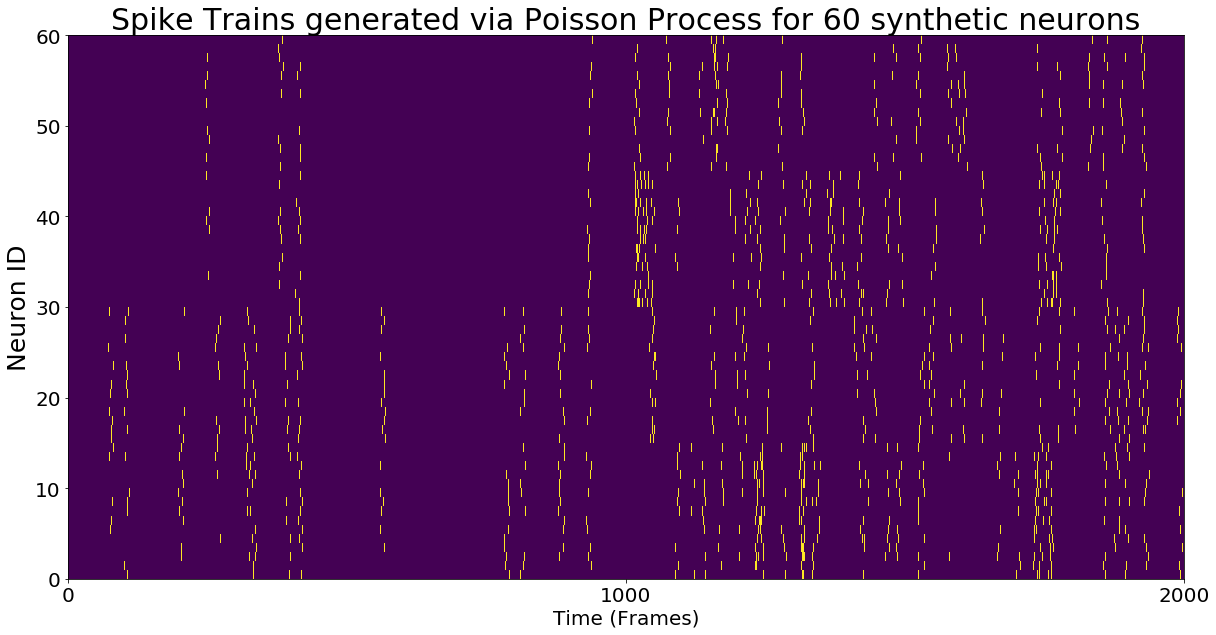

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,total_duration,0,num_neurons])
ax.set_title('Spike Trains generated via Poisson Process for %d synthetic neurons'%num_neurons, fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(int(total_duration/1000)+1)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

## 3) Divide the time series in half each having length 1000 frames & widen the spikes by multipyling each spike with a gaussian kernel with some standard deviation to increase the cross-correlation in 4)

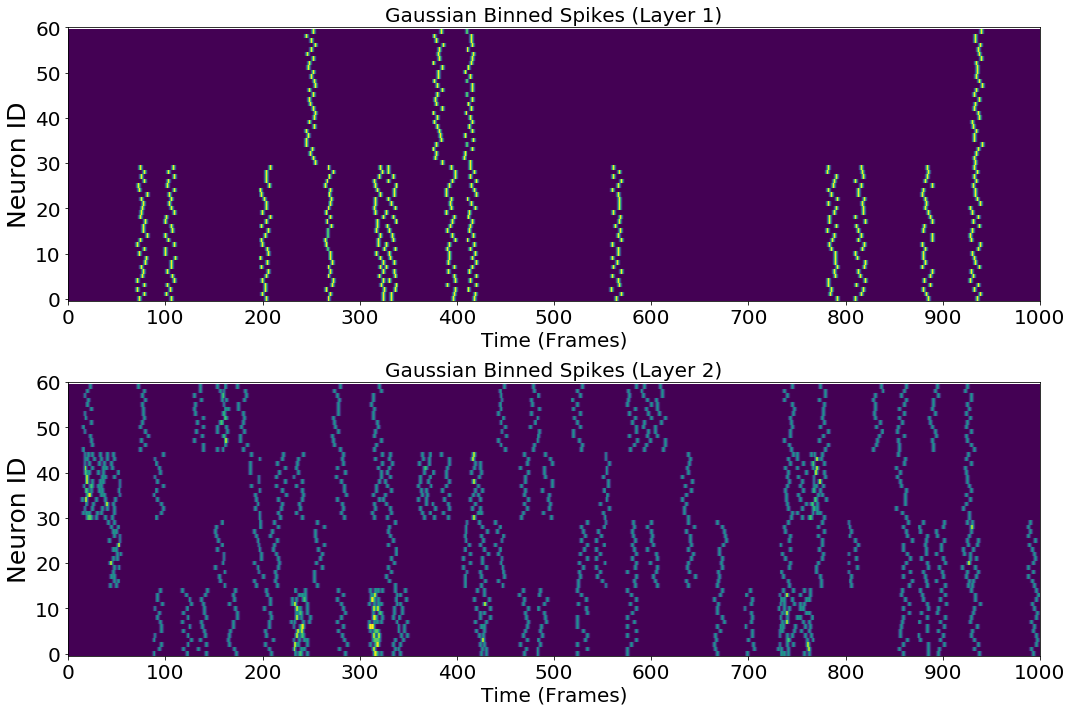

In [8]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,10))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Binned Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

## 4) Calculate the maximum positive cross correlation betwen pairs of neurons to create adjacency matrices

In [9]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


## 5) Display adjacency matrices

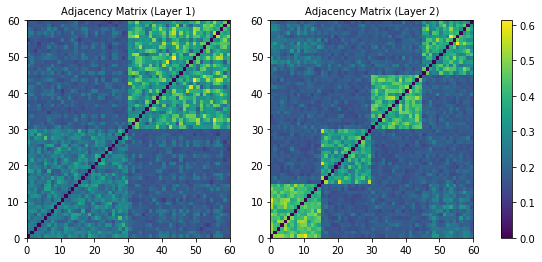

In [10]:
fig,ax = plt.subplots(1,layers, figsize = (5*layers,4))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 10)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 10)
cbar = fig.colorbar(k, ax = ax.flat)
cbar.ax.tick_params(labelsize = 10) 

In [11]:
thresholded_adjacency = []
thresh = 0.3
for i in range(layers):
    thresholded_adjacency.append(threshold(adjacency_matrices[i], thresh = thresh))

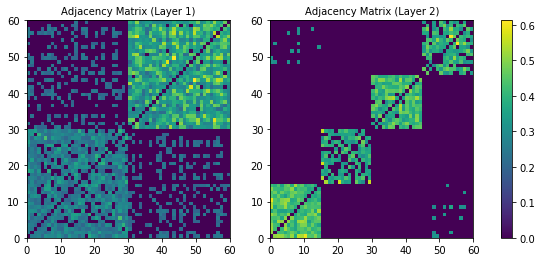

In [12]:
fig,ax = plt.subplots(1,layers, figsize = (5*layers,4))
for i in range(layers):
    k = ax[i].imshow(thresholded_adjacency[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 10)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 10)
cbar = fig.colorbar(k, ax = ax.flat)
cbar.ax.tick_params(labelsize = 10) 

In [13]:
def update_interlayer(self, spikes, X, omega_global, percentage, method):
        
    binned_spikes = self.bin_time_series(spikes, gaussian = False)
    sp = np.nonzero(binned_spikes)
        
    layers ,num_neurons, t = self.length, self.size, self.windowsize
        
    count_spikes = np.zeros((layers, num_neurons))
    interlayer = np.ones((layers-1, num_neurons))
    
    if method == 'local':
        for i in range(len(sp[0])):
            l, n, t = sp[0][i], sp[1][i], sp[2][i]
            count_spikes[l][n] = count_spikes[l][n] + 1
        interlayers = []
        for i in range(layers-1):
            zscores = zscore(np.diff(count_spikes, axis = 0)[i])
            layerweights = []
            for j in range(num_neurons):
                if zscores[j] <= X: layerweights.append(percentage*omega_global)
                else: layerweights.append(omega_global)
            interlayers.append(layerweights)

    elif method == 'global':
        for i in range(len(sp[0])):
            l, n, t = sp[0][i], sp[1][i], sp[2][i]
            count_spikes[l][n] = count_spikes[l][n] + 1
        interlayers = []
        zscores = zscore(np.mean(np.diff(count_spikes, axis = 0)))###changed np.mean from np.sum
        for i in range(layers-1):
            layerweights = []
            for j in range(num_neurons):
                if zscores[j] <= X: layerweights.append(percentage*omega_global)
                else: layerweights.append(omega_global)
            interlayers.append(layerweights)
    
        #TODO:::  elif method == 'adjacent':
    
    return(interlayers)

## 6) Add edges to the infomap object and run infomap

In [14]:
im = Infomap("--directed --silent --num-trials 5")
for i,e in enumerate(thresholded_adjacency):## list of length 2 corresponding to the adjacency matrices in each layer
    for j,f in enumerate(e):
        for k in range(len(f)):# f is each row of the adjacency matrix
            s = MultilayerNode(layer_id = i, node_id = j)
            t = MultilayerNode(layer_id = i, node_id = k)
            
            im.add_multilayer_link(s,t,f[k])

##diagonal coupling with interlayer coupling strength 1
for i in range(len(adjacency_matrices)-1):
    for j in range(num_neurons):# number of nodes which is 60 in the multilayer network
        s = MultilayerNode(layer_id = i, node_id = j)
        t = MultilayerNode(layer_id = i+1, node_id = j)
        im.add_multilayer_link(s, t, 1)
im.run()

In [15]:
dir(im)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__weakref__',
 '_initial_partition',
 'activeNetwork',
 'adaptDefaults',
 'addLink',
 'addMultilayerLink',
 'addName',
 'addNode',
 'addPhysicalNode',
 'addStateNode',
 'add_link',
 'add_links',
 'add_multilayer_link',
 'add_multilayer_links',
 'add_node',
 'add_nodes',
 'add_state_node',
 'add_state_nodes',
 'additionalInput',
 'aggregateFlowValuesFromLeafToRoot',
 'aggregatePerLevelCodelength',
 'alternateCoarseTuneLevel',
 'assignToNeighbouringModule',
 'begin',
 'benchmark',
 'bipartite',
 'bipartite_start_id',
 'calcCodelength',
 'calcCodelengthOnTree',
 'calcEntropyRate',
 'calculateMaxDepth',
 'calculateNumNo

In [16]:
im.states

AttributeError: 'Infomap' object has no attribute 'states'

## 7) Results

In [24]:
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

print("\n#layer_id node_id module_id:")
for node in im.nodes:
    print(f"{node.layer_id} {node.node_id} {node.module_id}")

Found 3 modules with codelength: 5.247832975852552

#layer_id node_id module_id:
0 49 1
0 56 1
0 43 1
0 57 1
0 40 1
0 45 1
0 39 1
0 53 1
0 55 1
0 33 1
0 52 1
0 38 1
0 50 1
0 47 1
0 30 1
0 46 1
0 32 1
0 31 1
0 36 1
0 42 1
0 59 1
0 37 1
0 41 1
0 58 1
0 44 1
0 48 1
0 51 1
0 54 1
0 35 1
0 34 1
0 0 1
0 14 1
0 6 1
0 22 1
0 7 1
0 26 1
0 1 1
0 16 1
0 20 1
0 27 1
0 8 1
0 19 1
0 5 1
0 25 1
0 11 1
0 21 1
0 17 1
0 10 1
0 3 1
0 28 1
0 13 1
0 9 1
0 12 1
0 2 1
0 15 1
0 23 1
0 29 1
0 4 1
0 24 1
0 18 1
1 38 1
1 43 1
1 40 1
1 36 1
1 44 1
1 35 1
1 31 1
1 42 1
1 41 1
1 34 1
1 32 1
1 33 1
1 39 1
1 30 1
1 37 1
1 8 2
1 0 2
1 5 2
1 1 2
1 6 2
1 4 2
1 12 2
1 9 2
1 14 2
1 10 2
1 2 2
1 3 2
1 13 2
1 11 2
1 7 2
1 53 2
1 51 2
1 57 2
1 46 2
1 54 2
1 52 2
1 56 2
1 48 2
1 55 2
1 50 2
1 49 2
1 58 2
1 45 2
1 59 2
1 47 2
1 16 3
1 23 3
1 15 3
1 21 3
1 27 3
1 29 3
1 26 3
1 25 3
1 20 3
1 22 3
1 18 3
1 17 3
1 28 3
1 24 3
1 19 3


In [40]:
dtype = [('layer',int),('nodeid',int),('module', int)]
ordered_set = []
for node in im.nodes:
    ordered_set.append((node.layer_id,node.node_id,node.module_id))
ordered_nodes = np.array(ordered_set , dtype = dtype)
[node[2] for node in np.sort(ordered_nodes, order = ['layer', 'nodeid'])]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [43]:
ordered_nodes = np.array(ordered_set , dtype = dtype)
k = [node[2] for node in np.sort(ordered_nodes, order = ['layer', 'nodeid'])]
k

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [21]:
membership = [[] for i in range(im.num_top_modules)]
for node in im.nodes:
    membership[int(node.module_id-1)].append((node.node_id, node.layer_id))

In [22]:
k = [node.module_id for node in im.nodes]
k

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

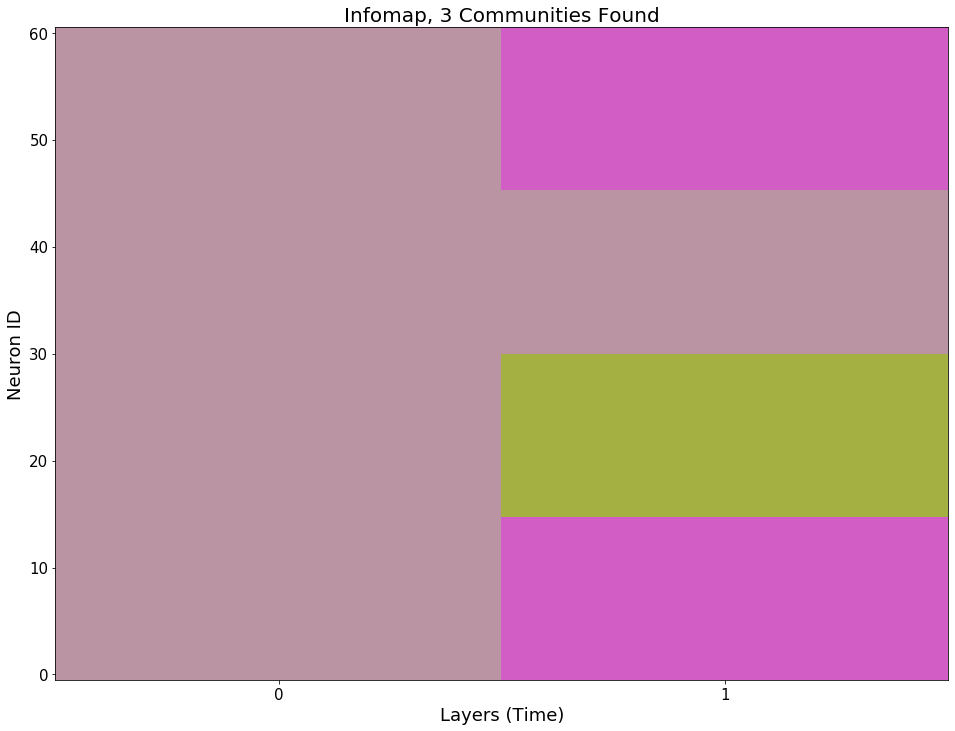

In [23]:
fig,ax = plt.subplots(1,1, figsize = (16,12))
c, comms = community(num_neurons, 2, membership, ax)

## cCR template

In [196]:
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

padded_adjacencies = [adjacency_matrices[0]]  + adjacency_matrices + [adjacency_matrices[-1]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [197]:
grid = 5

threshs = np.linspace(0, 0.8, grid)
interlayers = np.linspace(0, 2, grid)

memberships = {}
C = np.zeros((grid*grid, num_neurons*(layers+2)))

for i, thresh in enumerate(threshs):
    thresholded_adjacency = []
    inter_membership = []
    for j, interlayer in enumerate(interlayers):
        im = Infomap("--two-level --directed --silent")
        ######### Make Network
        ## add intra edges
        for l in range(layers+2):
            thresholded_adjacency.append(threshold(padded_adjacencies[l], thresh = thresh))
            for n1,e in enumerate(thresholded_adjacency[l]):## list of length 2 corresponding to the adjacency matrices in each layer
                for n2,w in enumerate(e):
                    s = MultilayerNode(layer_id = l, node_id = n1)
                    t = MultilayerNode(layer_id = l, node_id = n2)
                    im.add_multilayer_link(s, t, w)
        ## add inter edges            
        for l in range(layers+1):
            for k in range(num_neurons):
                s = MultilayerNode(layer_id = l, node_id = k)
                t = MultilayerNode(layer_id = l+1, node_id = k)
                im.add_multilayer_link(s, t, interlayer)
        #########
        im.run()
        membership = [[] for i in range(im.num_top_modules)]
        for node in im.nodes:
            membership[int(node.module_id-1)].append((node.node_id, node.layer_id))
        inter_membership.append(membership)
        C[i*grid+j,:] = [node.module_id for node in im.nodes]
        
    memberships['threshold=%.3f'%thresh] = inter_membership

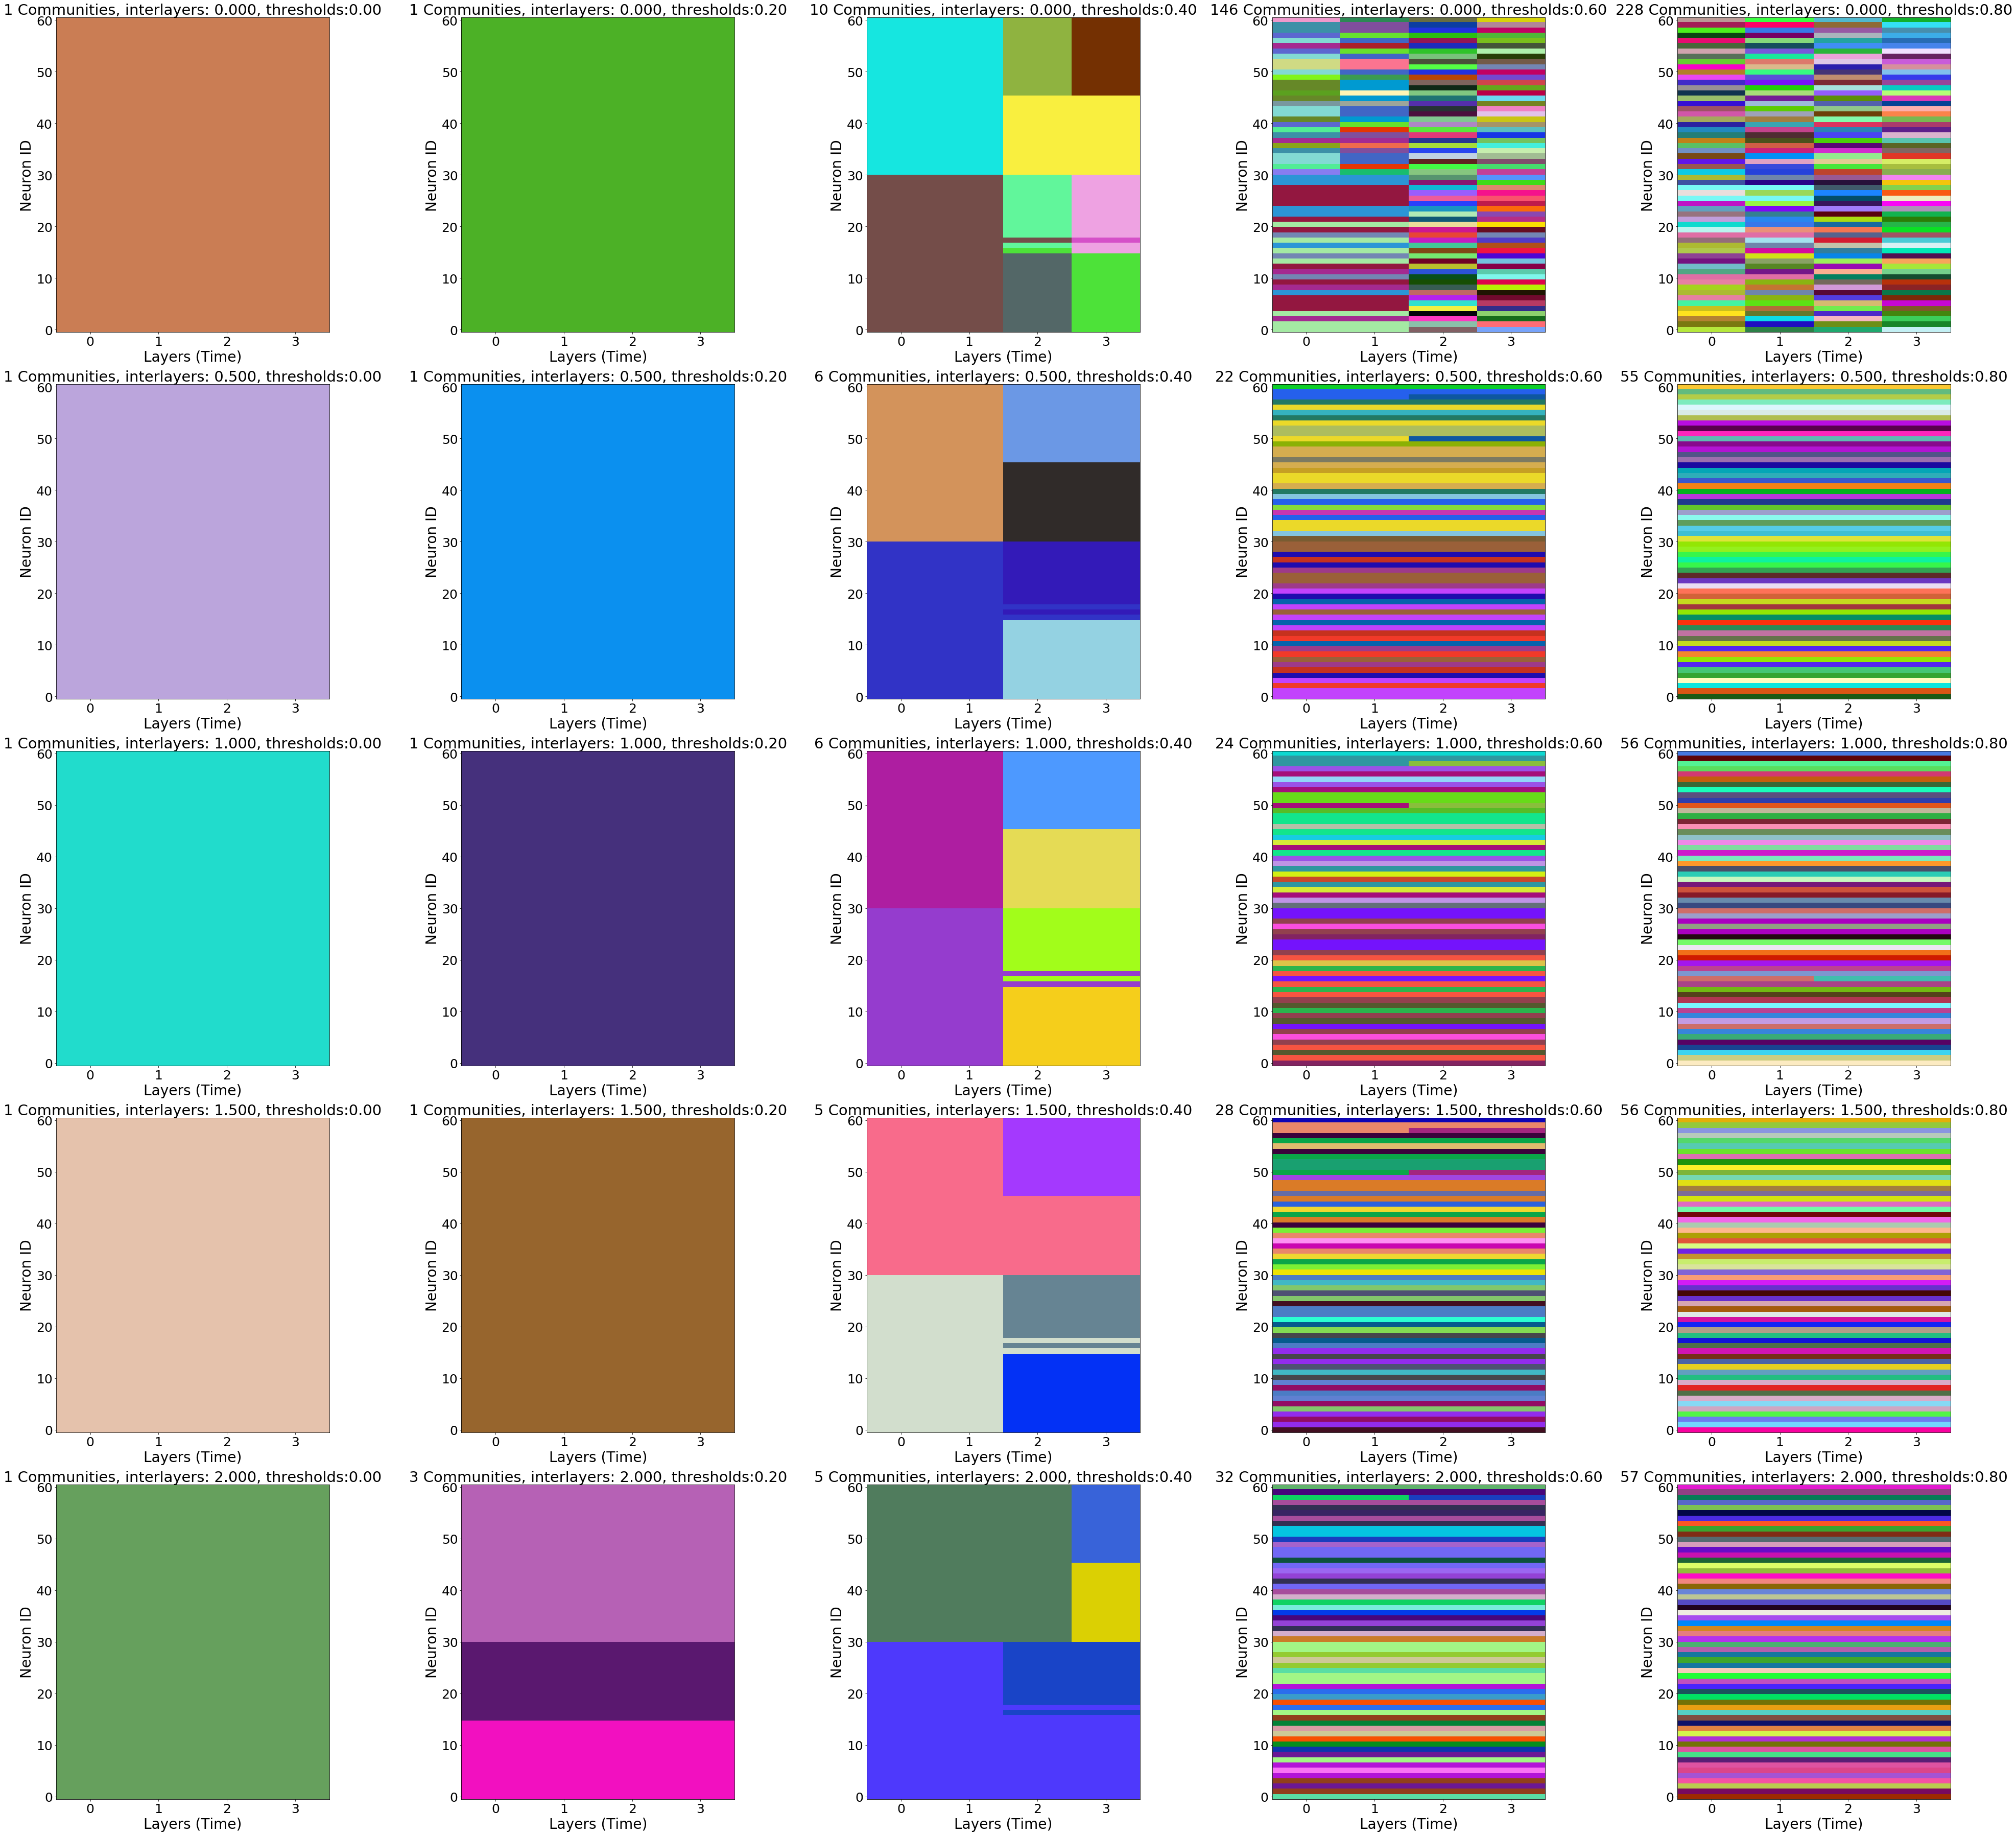

In [198]:
index = 5
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = community(num_neurons, layers+2, memberships['threshold=%.3f'%threshs[i]][j], ax[j][i])
        ax[j][i].set_xticks([i for i in range(layers+2)])
        ax[j][i].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax[j][i].tick_params(axis = 'both', labelsize = 25)
        ax[j][i].set_xlabel('Layers (Time)', fontsize = 28)
        ax[j][i].set_ylabel('Neuron ID', fontsize = 28)
        ax[j][i].set_title('%d Communities, interlayers: %.3f, thresholds:%.2f'%(len(c),interlayers[j],threshs[i]), fontsize=29)
plt.tight_layout()

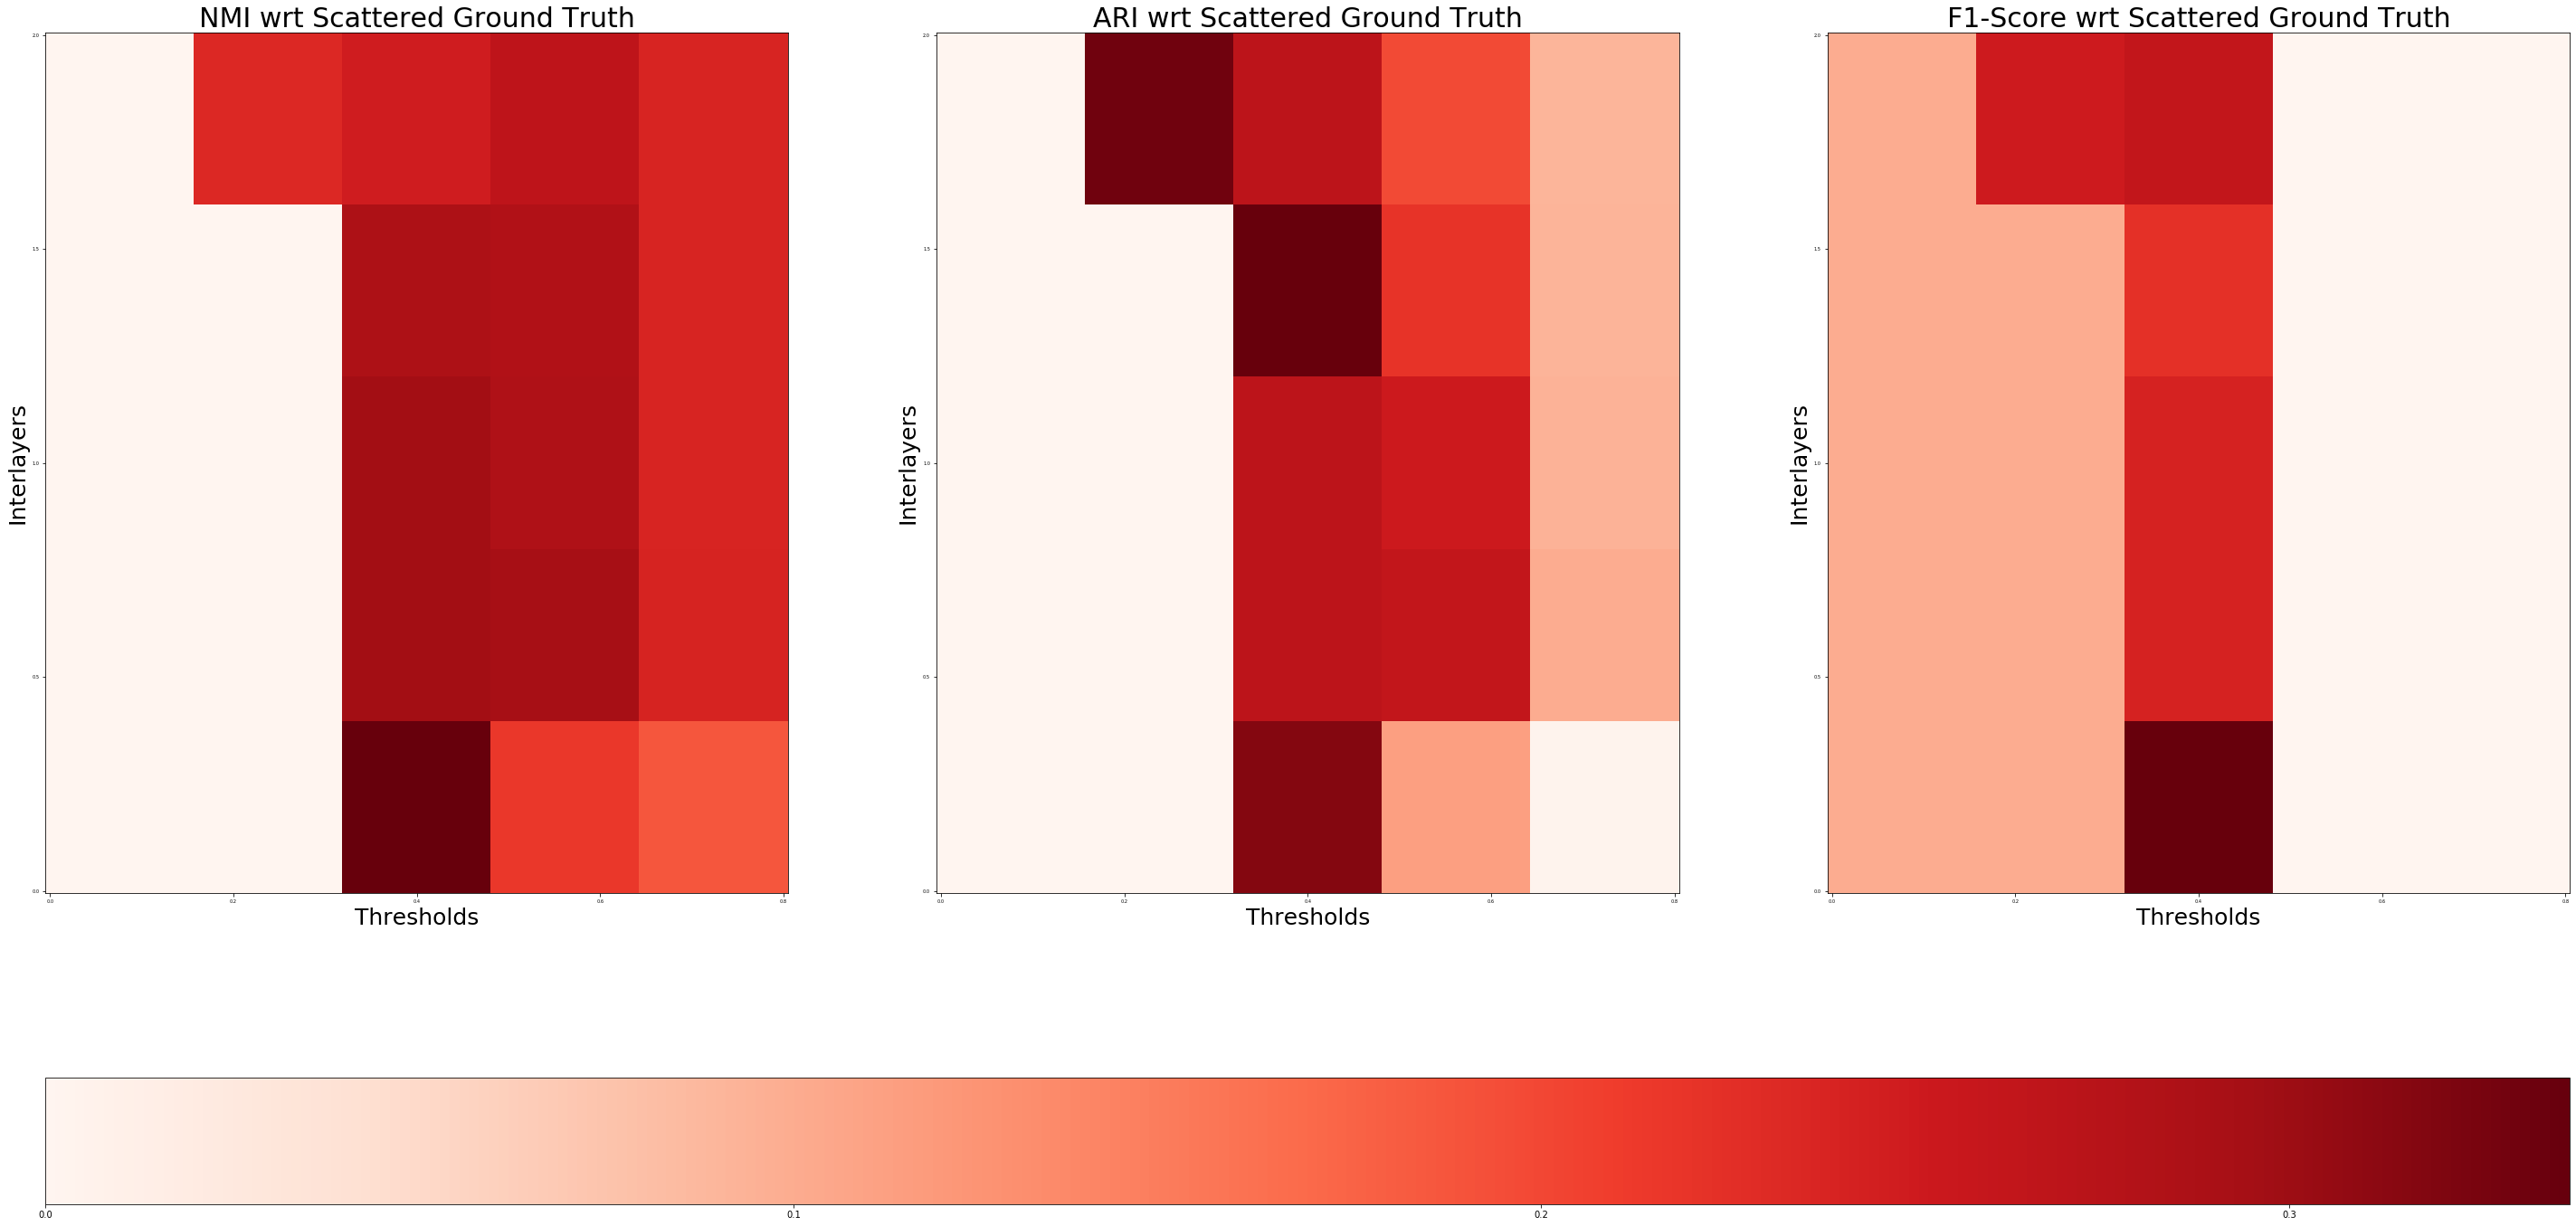

In [199]:
information_recovery(C, comm_sizes, 'Scattered', interlayers, threshs, 'merge')

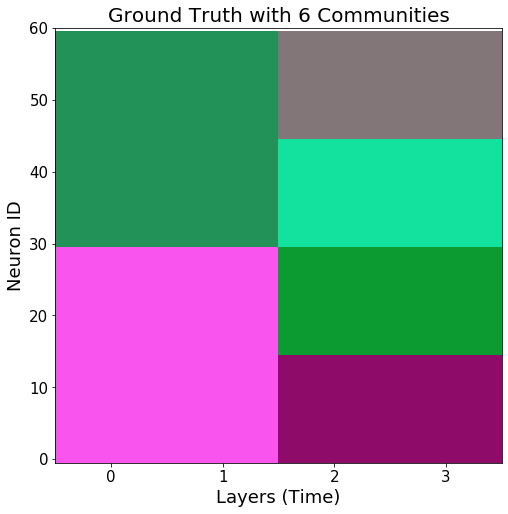

In [200]:
display_truth(comm_sizes, community_operation = 'merge')

In [134]:
from scipy.spatial.distance import jensenshannon
thresholded_adjacency = []
thresh = 0.2
for i in range(layers):
    thresholded_adjacency.append(threshold(adjacency_matrices[i], thresh = thresh))
    
method = 'neighborhood'
if method == 'local' :pass
elif method == 'neighborhood':
            ##utilizes the method from the paper: 
            #'Constrained information flows in temporal networks reveal intermittent communities, Ulf Aslak, 2018'
            ## jensenshannong divergence is 1 if the vectors are not similar and it's 0 if they ar         
    interlayers = []
    for i in range(layers-1):
        layerweights = []
        for j in range(num_neurons):
            JSD = jensenshannon(thresholded_adjacency[i][j,:], thresholded_adjacency[i+1][j,:])
            if JSD > -1: layerweights.append(1 - JSD**2) ## for non NaNs
            else: layerweights.append(0)
            # for NaNs assign an interlayer weight of 1, that is a higher dissimilarity in the JS divergence
        interlayers.append(layerweights)

In [201]:
def get_normalized_outlinks(layers, num_neurons, interlayer, thresholded_adjacency):    
    interlayer_indices = {}
    interlayer_weights = {}
    for i in range(layers):
        layerweights = []
        for j in range(num_neurons):
            maximal_neighbors = [[int(interlayer),j]]
            for nonzero in np.nonzero(thresholded_adjacency[i][j,:])[0]:
                maximal_neighbors.append([thresholded_adjacency[i][j,nonzero], nonzero])
            weights = np.array(sorted(maximal_neighbors, reverse = True))[:,0]
            indices = np.array(sorted(maximal_neighbors, reverse = True))[:,1]
            norm_weights = weights/np.sum(weights)
            indices, norm_weights
            interlayer_indices['%d,%d'%(i,j)] = indices
            interlayer_weights['%d,%d'%(i,j)] = norm_weights
    return(interlayer_indices,interlayer_weights)

In [193]:
from scipy.spatial.distance import jensenshannon
indices, weights = get_normalized_outlinks(2, 60, 1, thresholded_adjacency)
def neighborhood_flow(layer, node, interlayer_indices, interlayer_weights, thresh):
    length = int(min(len(interlayer_weights['%d,%d'%(layer,node)]),len(interlayer_weights['%d,%d'%(layer+1,node)]))*thresh)
    w = 1-jensenshannon(interlayer_weights['%d,%d'%(layer,node)][:length],interlayer_weights['%d,%d'%(layer+1,node)][:length])**2
    nbr = interlayer_indices['%d,%d'%(layer,node)][:length]
    return(w,nbr)

In [194]:
neighborhood_flow(0, 34, indices, weights, thresh)

(0.998169169333401, array([34., 57., 58., 37., 48., 47.]))

In [202]:
grid = 5

threshs = np.linspace(0, 0.8, grid)
interlayers = np.linspace(0, 2, grid)

memberships = {}
C = np.zeros((grid*grid, num_neurons*(layers+2)))

for i, thresh in enumerate(threshs):
    thresholded_adjacency = []
    inter_membership = []
    for j, interlayer in enumerate(interlayers):
        im = Infomap("--two-level --directed --silent")
        ######### Make Network
        ## add intra edges
        for l in range(layers+2):
            thresholded_adjacency.append(threshold(padded_adjacencies[l], thresh = thresh))
            for n1,e in enumerate(thresholded_adjacency[l]):## list of length 2 corresponding to the adjacency matrices in each layer
                for n2,w in enumerate(e):
                    s = MultilayerNode(layer_id = l, node_id = n1)
                    t = MultilayerNode(layer_id = l, node_id = n2)
                    im.add_multilayer_link(s, t, w)
        ## add inter edges  
        indices, weights = get_normalized_outlinks(layers, num_neurons, interlayer, thresholded_adjacency)
        for l in range(layers+1):
            for k in range(num_neurons):
                w, nbr = neighborhood_flow(l, k, indices, weights, thresh)
                for n in nbr:
                    s = MultilayerNode(layer_id = l, node_id = k)
                    t = MultilayerNode(layer_id = l+1, node_id = n)
                    im.add_multilayer_link(s, t, w)
        #########
        im.run()
        membership = [[] for i in range(im.num_top_modules)]
        for node in im.nodes:
            membership[int(node.module_id-1)].append((node.node_id, node.layer_id))
        inter_membership.append(membership)
        C[i*grid+j,:] = [node.module_id for node in im.nodes]
        
    memberships['threshold=%.3f'%thresh] = inter_membership

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
